# Nome: Gabriel Delgado Panovich de Barros
# RA: 176313

# Sobre o dataset
---
> Este arquivo foi copiado diretamente da [fonte](https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification) dos dados, com exceção das imagens.

## Context

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

## Content

The dataset was originally published by Skybox as part of their CS:GO AI Challenge, running from Spring to Fall 2020. The data set consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. Following the initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411.

Skybox website: https://skybox.gg/

Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive

View CS:GO on Steam Store: https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/

Find in-depth information on competitive CS:GO: https://www.hltv.org/

## Acknowledgements

Thanks to Skybox for taking the time to sample all the snapshots and organising the challenge. It wouldn't be possible to publish any of this without their help.

## Inspiration

- What types of machine learning models perform best on this dataset?
- Which features are most indicative of which teams wins the round?
- How often does the team with most money win?
- Are some weapons favourable to others?
- What attributes should your team have to win? Health, armor or money?

## Data Dictionary
Note: All snapshots are i.i.d in the sense that they each describe the state of a round
and can therefore be treated individually. Although multiple snaphots can be taken from the same round.

You are suppose to predict a label (round winner) based on each individual snapshot.

|Variable	     |Definition	                                        |Key                                      |
|----------------|------------------------------------------------------|-----------------------------------------|
|time_left       |The time left in the current round.                   |                                         |
|ct_score        |The current score of the Counter-Terrorist team.      |                                         |
|t_score         |The current score of the Terrorist team.              |                                         |
|map             |The map the round is being played on.	                |E.g. de_dust2, de_inferno and de_overpass|
|bomb_planted    |If the bomb has been planted or not.	                |False = No, True = Yes                   |
|ct_health       |The total health of all Counter-Terrorist players.	|Player health in range 0-100.            |
|t_health        |The total health of all Terrorist players.	        |Player health in range 0-100.            |
|ct_armor        |The total armor of all Counter-Terrorist players.	    |                                         |
|t_armor         |The total armor of all Terrorist players.	            |                                         |
|ct_money        |The total bankroll of all Counter-Terrorist players.  |Amount in USD.                           |
|t_money         |The total bankroll of all Terrorist players.	        |Amount in USD.                           |
|ct_helmets      |Number of helmets on the Counter-Terrorist team.	    |                                         |
|t_helmets       |Number of helmets on the Terrorist team.	            |                                         |
|ct_defuse_kits  |Number of defuse kits on the Counter-Terrorist team.  |	                                      |
|ct_players_alive|Number of alive players on the Counter-Terrorist team.|Range 0 to 5.                            |
|t_players_alive |Number of alive players on the Terrorist team.	    |Range 0 to 5.                            |
|ct_weapon_X     |Weapon X count on Counter-Terrorist team.	            |E.g. Ak47, Deagle and UMP45.             |
|t_weapon_X      |Weapon X count on Terrorist team.	                    |E.g. Ak47, Deagle and UMP45.             |
|ct_grenade_X    |Grenade X count on Counter-Terrorist team.            |E.g. HeGrenade, Flashbang.               |
|t_grenade_X     |Grenade X count on Terrorist team.	                |E.g. HeGrenade, Flashbang.               |
|round_winner    |Winner.	                                            |CT = Counter-Terrorist, T = Terrorist    |

# Objetivo do modelo de rede neural
---
A função desta rede neural é ser capaz de prever qual time (Terroristas ou Contraterroristas) vencerá a rodada da partida, jogada em uma melhor de 30 rodadas.

Utilizamos os dados relativos à quantidade de jogadores vivos em cada time, a vida total dos jogadores de cada time, o dinheiro em USD de cada time, o tempo restante no final do round e se a bomba foi plantada, além do time que venceu a rodada.

# Resultados
---
A comparação da acurácia de cada modelo está no [final do caderno](#resultados-obtidos-resumo), incluindo o modelo com termo de momentum.

In [21]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import Compose
from typing import Dict, Tuple

# Preparação dos dados

In [ ]:
class CustomDB(Dataset):
    """ Classe que adapta o database para o formato desejado pela NN """
    def __init__(self, file_path, transform=None, target_transform=None):
        df = pd.read_csv(file_path)

        # Assumimos que as labels estão na última coluna do dataframe, então separamos as features como
        # todos os valores anteriores à última coluna e os labels como a última coluna. Todos esses valores
        # são convertidos para ndarrays, facilitando a integração com os tensores
        features_np = df.iloc[:, :-1].values
        labels_np = df.iloc[:, -1].values

        self.features = torch.tensor(features_np, dtype=torch.float32)
        self.labels = torch.tensor(labels_np, dtype=torch.float32)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature_sample = self.features[idx]
        label_sample = self.labels[idx]

        # Realiza as transformações, caso solicitadas
        if self.transform:
            feature_sample = self.transform(feature_sample)
        if self.target_transform:
            label_sample = self.target_transform(label_sample)

        return feature_sample, label_sample

def normalize_subset(subset, mean, std):
    """ Função auxiliar para aplicar a normalização """
    features = torch.cat([subset[i][0].unsqueeze(0) for i in range(len(subset))], dim=0)
    labels = torch.tensor([subset[i][1] for i in range(len(subset))])
    
    # Normalização
    normalized_features = (features - mean) / std
    # Formato mais otimizado para armazenar o dataset pronto para ser carregado no dataloader
    return TensorDataset(normalized_features, labels.unsqueeze(1))

def prepareData(path: str,
                proportion: Tuple[float, float, float],
                batch_size: int = 32) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Recebe o caminho de um dataset e retorna os dados processados e preparados para serem utilizados
    no processo de aprendizado do modelo.

    ENTRADA:
        path: Caminho do arquivo.
        proportion: Proporção em que os dados serão divididos para cada conjunto. São respectivamente os conjuntos de
        treino, validação eteste. Ex: (0.8, 0.1, 0.1)
        batch_size (opcional): Tamanho dos lotes nos dataloaders.
    SAÍDA:
        Tuple[torch.tensor, torch.tensor, torch.tensor]: Tupla que contém, respectivamente, os dados de treino, validação
        e teste aleatorizados e normalizados.
    """
    # --- 1. Carregamos o dataset completo, para uma divisão posterior ---
    full_data = CustomDB(file_path=path)

    # --- 2. Calculamos o tamanho de cada conjunto ---
    dataset_size = len(full_data)
    train_size = int(dataset_size * proportion[0])
    val_size = int(dataset_size * proportion[1])
    test_size = dataset_size - train_size - val_size # garantimos que cobriremos o dataset completo

    # Geramos uma seed para a aleatorização dos dados
    generator = torch.Generator().manual_seed(42)
    # --- 3. Dividimos os dados do dataset ---
    train_subset, val_subset, test_subset = random_split(
        full_data,
        [train_size, val_size, test_size],
        generator=generator
    )

    # --- 4. Etapa de normalização dos dados ---
    # Usamos o método de normalização por distribuição
    # dim=0 indica que estamos trabalhando com as colunas
    train_features = torch.cat([train_subset[i][0].unsqueeze(0) for i in range(len(train_subset))], dim=0)
    mean = train_features.mean(dim=0)
    std = train_features.std(dim=0)
    # Evita divisão por zero se uma feature for constante
    std[std == 0] = 1.0

    train_normalized = normalize_subset(train_subset, mean, std)
    val_normalized = normalize_subset(val_subset, mean, std)
    test_normalized = normalize_subset(test_subset, mean, std)

    # Construimos os DataLoaders de cada conjunto
    train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
    # Não aleatorizamos os conjuntos de validação e de teste pois queremos uma avaliação consistente
    val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def filterData(path: str = 'db/') -> None:
    """
    Função específica para o dataset escolhido. Filtra os dados para manter apenas:

    'ct_health',
    't_health',
    'ct_money',
    't_money',
    'time_left',
    'bomb_planted',
    'ct_players_alive',
    't_players_alive',
    'round_winner'

    ENTRADA:
        path: Caminho do dataset original, com exceção do arquivo em si.
    SAÍDA:
        None
    """
    # Carrega o arquivo CSV grande.
    db_path = os.path.join(path, 'csgo_round_snapshots.csv')
    df = pd.read_csv(db_path)

    # --- 1. Convertendo a coluna alvo (label) ---
    # Mapeia 'CT' para 1 e 'T' para 0
    df['round_winner_numeric'] = df['round_winner'].map({'CT': 1, 'T': 0})

    # --- 2. Converte a coluna bomb_planted para inteiros ---
    # False se torna 0 e True se torna 1
    df['bomb_planted'] = df['bomb_planted'].astype(int)

    # --- 3. Selecionando e ordenando as colunas finais ---
    # Lista com as features selecionadas por você
    features = [
        'ct_health',
        't_health',
        'ct_money',
        't_money',
        'time_left',
        'bomb_planted',
        'ct_players_alive',
        't_players_alive'
    ]

    # Coluna do label (alvo)
    label = 'round_winner_numeric'

    # Cria o DataFrame final com as features e o label como a ÚLTIMA coluna
    # Isso é importante para que nossa classe NumericalDataset funcione corretamente
    final_df = df[features + [label]]

    # --- 4. Salvando o novo arquivo CSV ---
    output_filename = 'csgo_processed.csv'
    final_path = os.path.join(path, output_filename)
    final_df.to_csv(final_path, index=False)

def viewData(path: str = 'db/') -> pd.DataFrame:
    arch = 'csgo_processed.csv'
    file_path = os.path.join(path, arch)

    df = pd.read_csv(file_path)
    return df

# Função de plotagem dos erros

In [24]:
def plotLosses(loss1: Dict[int, float], loss2: Dict[int ,float], loss1_label: str, loss2_label: str) -> None:
    plt.close("all")
    plt.figure()
    plt.plot(loss1.keys(), loss1.values(), label=loss1_label)
    plt.plot(loss2.keys(), loss2.values(), label=loss2_label)
    plt.title(f"{loss1_label} e {loss2_label}")
    plt.xlabel("Épocas")
    plt.ylabel("Erro")
    plt.legend()
    plt.show()

# Funções de treino e validação e de cálculo da acurácia final

In [ ]:
def trainModel(model: nn.Module, train_loader: DataLoader, loss_function, optimizer, device="cuda") -> float:
    """
    Função de treinamento do modelo, percorrendo uma época.

    ENTRADA:
        model: Modelo de rede neural a ser treinado.
        train_loader: DataLoader de treinamento.
        loss_function: Função de erro definida pelo usuário.
        optimizer: Método de cálculo da retropropagação.
        device: Dispositivo de aceleração utilizado.
    SAÍDA:
        avg_loss: Média do erro calculado nas iterações da época.
    """
    model.train() # Coloca o modelo em modo de treino
    total_loss = 0.0

    # Itera sobre o dataloader
    for features, labels in train_loader:
        # --- 1. Enviamos os dados para o dispositivo de aceleração ---
        features = features.to(device)
        labels = labels.to(device)
        # --- 2. Zeramos o gradiente da classe de gradiente estocástico ---
        optimizer.zero_grad()
        # --- 3. Feedforward ---
        # Passamos os features como x1, x2, ..., xn para o modelo gerar uma saída
        predict = model(features)
        # --- 4. Cálculo do erro da saída ---
        # Aplicação da função de erro
        out_loss = loss_function(predict, labels) # args: (saída do modelo, saída esperada)
        # --- 5. Retropropagação ---
        out_loss.backward()
        # --- 6. Atualização dos pesos com base na retropropagação ---
        optimizer.step()

        # Convertemos o erro (tensor) em um valor numérico
        total_loss += out_loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validateModel(model: nn.Module, val_loader: DataLoader, loss_function, device="cuda") -> float:
    """
    Função de validação do modelo, percorrendo uma época. Como não estamos treinando o modelo, não precisamos
    calcular o gradiente descendente estocástico, o qual é necessário para atualizar os pesos sinápticos dos
    neurônios das camadas ocultas.

    ENTRADA:
        model: Modelo de rede neural a ser treinado.
        val_loader: DataLoader de validação.
        loss_function: Função de erro definida pelo usuário.
        device: Dispositivo de aceleração utilizado.
    SAÍDA:
        avg_loss: Média do erro calculado nas iterações da época.
    """
    model.eval() # Coloca o modelo em modo de validação
    total_loss = 0.0
    
    with torch.no_grad(): # Desativa o cálculo do gradiente descendente para economizar processamento
        for features, labels in val_loader:
            # --- 1. Enviamos os dados para o dispositivo de aceleração ---
            features = features.to(device)
            labels = labels.to(device)
            # --- 2. Feedforward ---
            # Passamos os features como x1, x2, ..., xn para o modelo gerar uma saída
            predict = model(features)
            # --- 3. Cálculo do erro da saída ---
            out_loss = loss_function(predict, labels)
            # Convertemos o erro (tensor) em um valor numérico
            total_loss += out_loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

def testModel(model: nn.Module, test_loader: DataLoader, device="cuda") -> float:
    """
    Função de teste do modelo. Para ajuste das saídas, convertemos valores acima de 0.5 para 1.

    ENTRADA:
        model: Modelo de rede neural a ser treinado.
        test_loader: DataLoader de testew.
        device: Dispositivo de aceleração utilizado.
    SAÍDA:
        accuracy: Acurácia média do modelo.
    """
    model.eval()
    correct_cases = 0
    total_samples = 0

    with torch.no_grad():
        for features, labels in test_loader:
            # --- 1. Enviamos os dados para o dispositivo de aceleração ---
            features = features.to(device)
            labels = labels.to(device)
            # --- 2. Feedforward ---
            # Passamos os features como x1, x2, ..., xn para o modelo gerar uma saída
            outputs = model(features)
            # --- 3. Converte a saída (probabilidade) em uma classe (0 ou 1) ---
            # Se a saída for > 0.5, a classe prevista é 1, senão é 0.
            predicted = (outputs > 0.5).float()
            # --- 4. Contagem de samples e dos resultados corretos ---
            total_samples += labels.size(0)
            correct_cases += (predicted == labels).sum().item() # conversão para valores numéricos
    
    # --- 5. Calcula a acurácia final ---
    accuracy = 100 * correct_cases / total_samples
    return accuracy

# Modelo 1 - Linear sem camadas ocultas

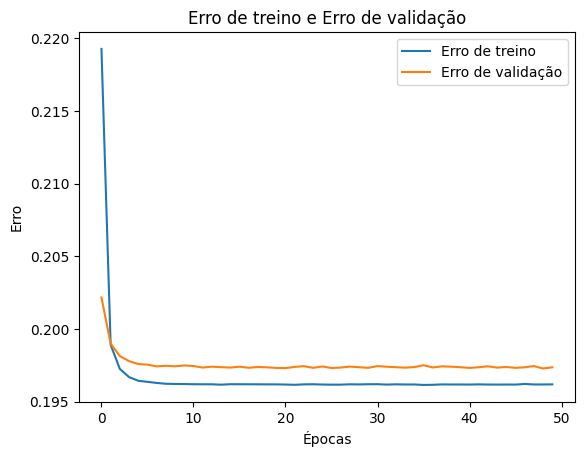

========= ACURÁCIA =========
67.49


In [ ]:
class LinearModel(nn.Module): # Estagnou por volta de 0.2 de erro em 20 épocas
    def __init__(self, in_features=8, out_features=1):
        """
        in_features: Número de features que o dataset possui
        out_features: Classificação binária
        """
        super(LinearModel, self).__init__() # instancia o nn.Module
        self.l1 = nn.Linear(in_features, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
# HIDDEN1_SIZE = 32
# HIDDEN2_SIZE = 4
# LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)


# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
model = LinearModel().to(device)
# model = LinearModel(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
linear_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{linear_accuracy:.2f}")

# Modelo 2 - MLP com 4 neurônios na camada oculta sem regularização

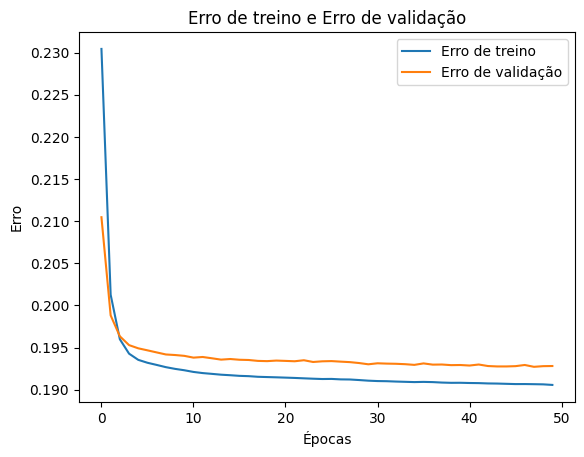

========= ACURÁCIA =========
67.61


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=4, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Passa para a camada de saída
        x = self.l2(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 4
# HIDDEN2_SIZE = 4
# LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)

# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2) # regularização L2
# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP4_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP4_accuracy:.2f}")

# Modelo 3 - MLP com 8 neurônios na camada oculta com regularização L2

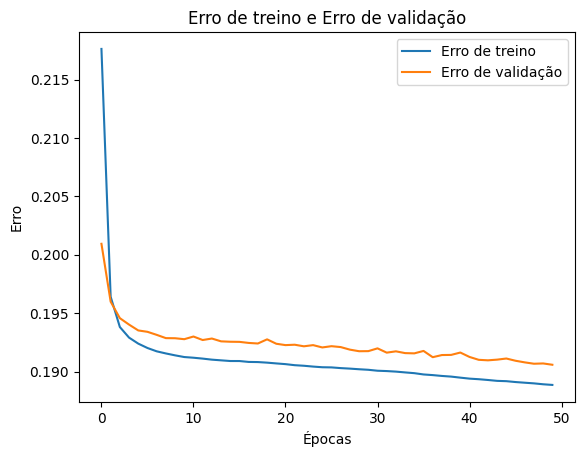

========= ACURÁCIA =========
68.22


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=8, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Passa para a camada de saída
        x = self.l2(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 8
# HIDDEN2_SIZE = 4
LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)

# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP8L2_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP8L2_accuracy:.2f}")

# Modelo 4 - MLP com 16 neurônios na camada oculta com regularização L2

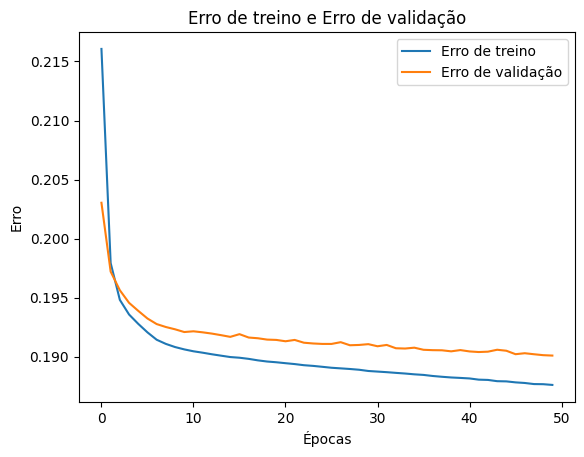

========= ACURÁCIA =========
68.39


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=16, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Passa para a camada de saída
        x = self.l2(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 16
# HIDDEN2_SIZE = 4
LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)

# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)


# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP16L2_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP16L2_accuracy:.2f}")

# Modelo 5 - MLP com 16 neurônios na camada oculta com regularização por dropout

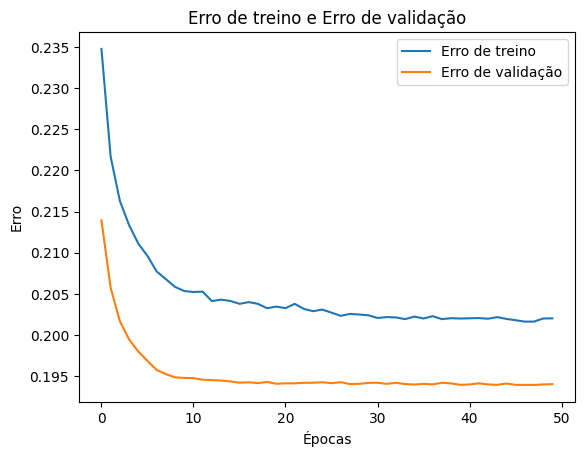

========= ACURÁCIA =========
67.21


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=16, out_features=1, dropout_prob=0.5):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Regularização
        self.dropout = nn.Dropout(p=dropout_prob)
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Dropout
        x = self.dropout(x)
        # 4. Passa para a camada de saída
        x =self.l2(x)
        # 5. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 8
# HIDDEN2_SIZE = 4
# LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)

# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)
# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP16D_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP16D_accuracy:.2f}")

# Modelo 6 - MLP com 32 neurônios na camada oculta com regularização L2

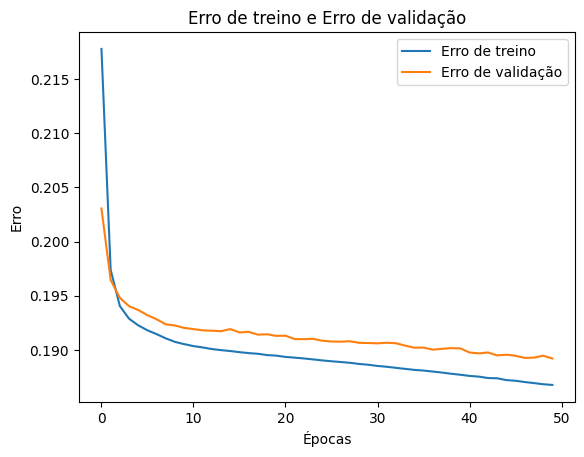

========= ACURÁCIA =========
69.19


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=32, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Passa para a camada de saída
        x = self.l2(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 32
# HIDDEN2_SIZE = 4
LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)


# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)

# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP32L2_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP32L2_accuracy:.2f}")

# Modelo 7 - MLP com 32 neurônios na primeira camada oculta e 16 na segunda camada oculta com regularização L2

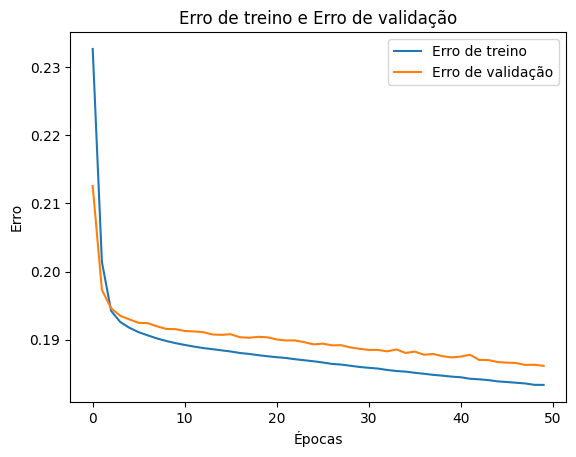

========= ACURÁCIA =========
69.19


In [ ]:
class MLP(nn.Module): # Modelo com duas camadas ocultas, mesmo problema dos anteriores (fiz apenas por desencargo de consciência).
    def __init__(self, in_features=8, hidden1_size=8, hidden2_size=4, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta 1
        self.l1 = nn.Linear(in_features, hidden1_size)
        # Função de ativação não-linear
        self.relu1 = nn.ReLU()
        # Camada de oculta 1 -> camada oculta 2
        self.l2 = nn.Linear(hidden1_size, hidden2_size)
        # Função de ativação não-linear
        self.relu2 = nn.ReLU()
        # Camada oculta 2 -> camada de saída
        self.l3 = nn.Linear(hidden2_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu1(x) 
        # 3. Passa para a próxima camada oculta
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 32
HIDDEN2_SIZE = 16
LAMBDA_L2 = 1e-5
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)

# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
# model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA_L2)

# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP_1_32_2_16L2_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP_1_32_2_16L2_accuracy:.2f}")

# Modelo 8 - MLP com 32 neurônios na camada oculta com regularização L2 e termo de momentum

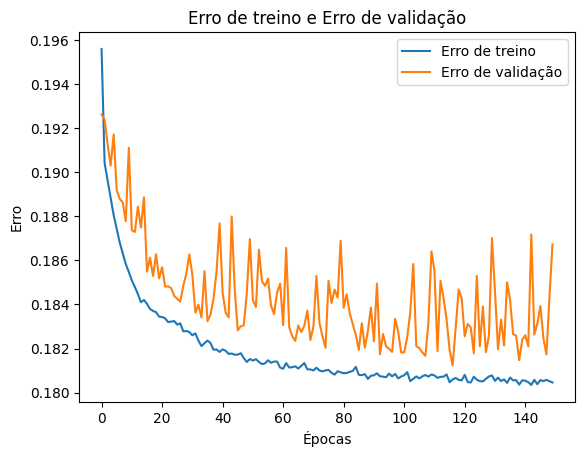

========= ACURÁCIA =========
69.63


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features=8, hidden_size=32, out_features=1):
        """
        in_features: Número de features que o dataset possui
        hidden_size: Número de neurônios na camada oculta
        out_features: Classificação binária
        """
        super(MLP, self).__init__() # instancia o nn.Module
        # Camada de entrada -> camada oculta
        self.l1 = nn.Linear(in_features, hidden_size)
        # Função de ativação não-linear
        self.relu = nn.ReLU()
        # Camada oculta -> camada de saída
        self.l2 = nn.Linear(hidden_size, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 1. Passa os dados para a camada linear
        # v = Σ(wx) + b
        x = self.l1(x)
        # 2. Passa os dados pela função não-linear
        # v = max(0,x)
        x = self.relu(x) 
        # 3. Passa para a camada de saída
        x = self.l2(x)
        # 4. Função do campo local induzido (não-linear)
        # y = φ(v)
        x = self.sigmoid(x)
        
        return x

EPOCHS = 50
HIDDEN1_SIZE = 32
# HIDDEN2_SIZE = 4
LAMBDA_L2 = 1e-5
MOMENTUM = 0.9
PATH = os.path.join("db/","csgo_processed.csv")
PROPORTION = (0.8, 0.1, 0.1)


# Carregamos os dados localmente
# Args: (Caminho do dataset, Tupla de proporção=(Treino, Validação, Teste))
train_loader, val_loader, test_loader = prepareData(PATH, PROPORTION)

# Definimos o uso de CUDA para o treinamento do modelo
device = "cuda" if torch.accelerator.is_available() else "cpu"
# --- 1. Instanciação do modelo ---
torch.manual_seed(42)
# model = Linear().to(device)
model = MLP(hidden_size=HIDDEN1_SIZE).to(device)
# model = MLP(hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE).to(device)
# --- 2. Definição da função de erro ---
# Soma dos erros quadráticos, como descrito na documentação
loss_function = nn.MSELoss() # mean squared error
# --- 3. Definição do gradiente estocástico (otimizador) com regularização L2 ---
learning_rate = 0.01 # eta
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            weight_decay=LAMBDA_L2,
                            momentum=MOMENTUM)

# --- 4. Treinamento e validação do modelo ---
# Armazenamos os erros seguindo o padrão {época: erro obtido}
train_loss = {}
val_loss = {}
for i in range(EPOCHS):
    loss = trainModel(model, train_loader, loss_function, optimizer)
    train_loss[i] = loss

    loss = validateModel(model, val_loader, loss_function)
    val_loss[i] = loss

plotLosses(train_loss, val_loss, "Erro de treino", "Erro de validação")
MLP32L2M_accuracy = testModel(model, test_loader)
print("========= ACURÁCIA =========")
print(f"{MLP32L2M_accuracy:.2f}")

# Resultados obtidos (resumo)

In [38]:
print("================================================== RESULTADOS FINAIS ==================================================")
print(f"Acurácia do modelo 1 (linear simples):                                                 {linear_accuracy:.2f}")
print(f"Acurácia do modelo 2 (MLP com 4 neurônios ocultos):                                    {MLP4_accuracy:.2f}")
print(f"Acurácia do modelo 3 (MLP com 8 neurônios ocultos e regularização L2):                 {MLP8L2_accuracy:.2f}")
print(f"Acurácia do modelo 4 (MLP com 16 neurônios ocultos e regularização L2):                {MLP16L2_accuracy:.2f}")
print(f"Acurácia do modelo 5 (MLP com 16 neurônios ocultos e dropout):                         {MLP16D_accuracy:.2f}")
print(f"Acurácia do modelo 6 (MLP com 32 neurônios ocultos e regularização L2):                {MLP32L2_accuracy:.2f}")
print(f"Acurácia do modelo 7 (MLP com 32 e 16 neurônios ocultos e regularização L2)            {MLP_1_32_2_16L2_accuracy:.2f}") # até é mais eficiente, mas com um custo desnecessariamente maior
print(f"Acurácia do modelo 8 (MLP com 32 neurônios ocultos e regularização L2 e momentum):     {MLP32L2M_accuracy:.2f}")

================================================== RESULTADOS FINAIS ==================================================
Acurácia do modelo 1 (linear simples):                                                 67.49
Acurácia do modelo 2 (MLP com 4 neurônios ocultos):                                    67.61
Acurácia do modelo 3 (MLP com 8 neurônios ocultos e regularização L2):                 68.22
Acurácia do modelo 4 (MLP com 16 neurônios ocultos e regularização L2):                68.39
Acurácia do modelo 5 (MLP com 16 neurônios ocultos e dropout):                         67.21
Acurácia do modelo 6 (MLP com 32 neurônios ocultos e regularização L2):                69.19
Acurácia do modelo 7 (MLP com 32 e 16 neurônios ocultos e regularização L2)            69.23
Acurácia do modelo 8 (MLP com 32 neurônios ocultos e regularização L2 e momentum):     69.63
